In [2]:
import scipy.io as sio

import cmocean as cm
import gsw
from geopy.distance import distance as geopy_distance
import scipy.signal as signal

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
plt.rcParams.update({
    "figure.facecolor":  "white",  
    "savefig.facecolor": "white",  
})

import numpy as np
import pandas as pd
import datetime 


import cartopy.crs as ccrs
import cartopy.feature 

import helper_functions as helper
from location import Location
from ctd_cast import CTDCast

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

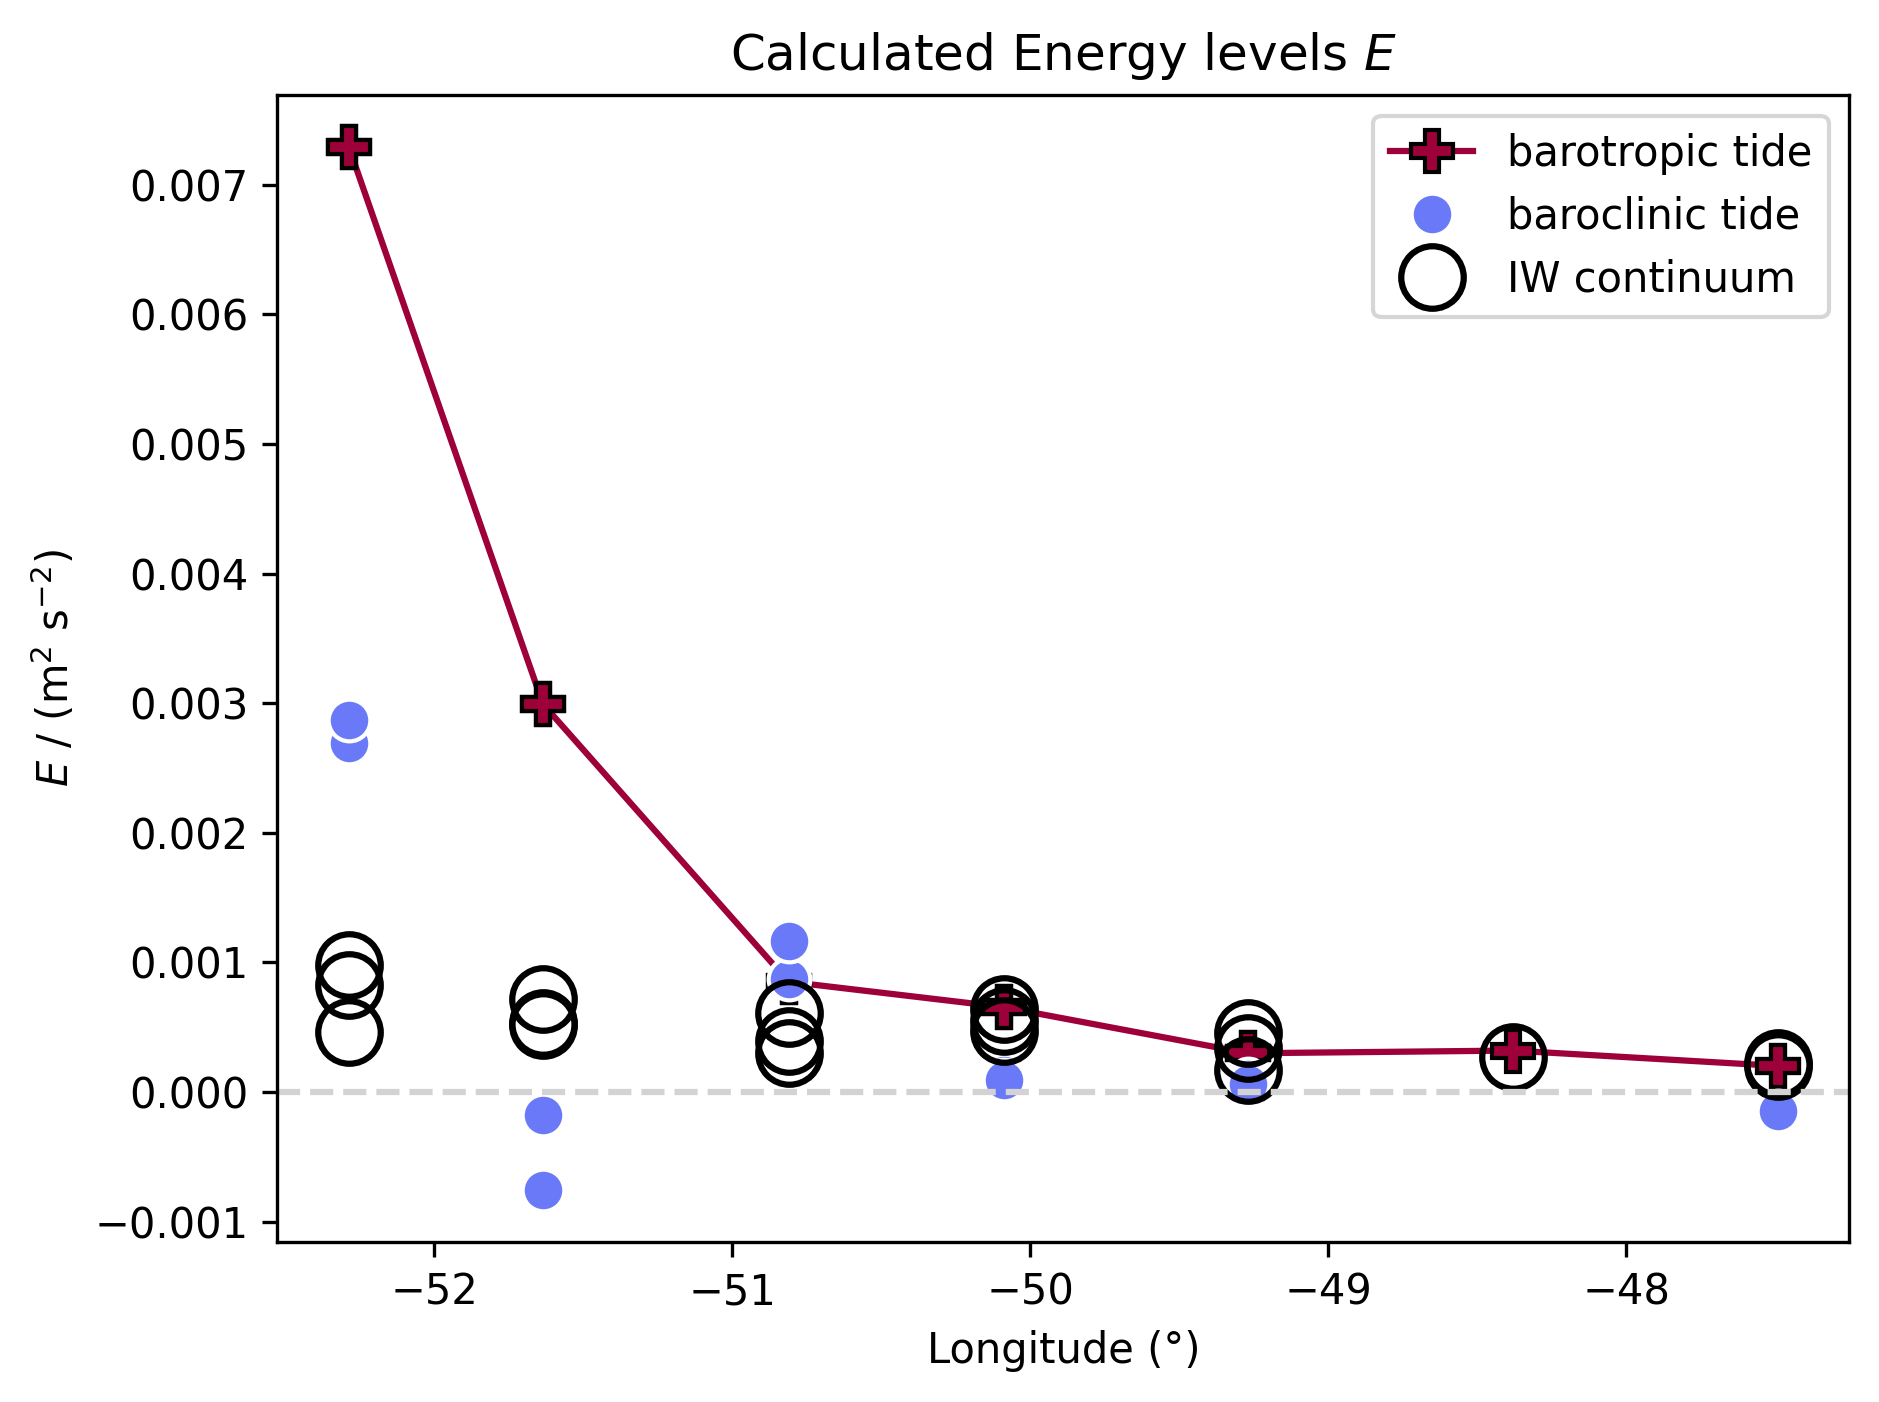

In [4]:
from IPython.display import Image, display;   
display(Image(filename='/home/ole/Desktop/Mooring_Analysis/figures/EGU Supplementary Material/figures/energy_distrib.png', width = 600))

In [5]:
# Load energy levels
data = np.load("./data/integrated_levels.npz", allow_pickle = True) 
#barotropic = data["barotropic"]
#baroclinic = data["baroclinic"]
energy_levels = pd.DataFrame(data = {
    "lon":data["lons"], 
    "lat":data["lats"], 
    "IW":data["IW"], 
    "barotropic":data["barotropic"],
    "baroclinic":data["baroclinic"],
    "rounded_depths": data["rounded_depths"]
})

energy_levels["rounded_depths"] = energy_levels["rounded_depths"].astype("int")

energy_levels["energy_level"] = energy_levels["IW"] + energy_levels["barotropic"] + energy_levels["baroclinic"].fillna(0)

energy_levels

,lon,lat,IW,barotropic,baroclinic,rounded_depths,energy_level
0,-52.2870,-63.4032,0.000467,0.007290,NaN,299,0.007756
1,-52.2870,-63.4032,0.000826,0.007290,0.002692,505,0.010808
2,-52.2870,-63.4032,0.000983,0.007290,0.002872,614,0.011144
3,-51.6357,-63.5145,0.000532,0.002993,NaN,1318,0.003525
4,-51.6357,-63.5145,0.000715,0.002993,-0.000179,1513,0.003529
5,-51.6357,-63.5145,0.000515,0.002993,-0.000755,1625,0.002752
6,-50.8113,-63.6560,0.000394,0.000851,0.000869,2143,0.002114
7,-50.8113,-63.6560,0.000609,0.000851,0.001166,2350,0.002626
8,-50.8113,-63.6560,0.000299,0.000851,NaN,750,0.001150
9,-50.0897,-63.7783,0.000545,0.000655,NaN,2400,0.001201


In [6]:
# Add Meters Above Bottom dimension
data = np.load("/home/ole/Desktop/Mooring_Analysis/notebooks/poster_temperature_data.npz")
mab_df = pd.DataFrame(data = {"lon": data["uv_lon"], "rounded_depths": data["uv_depth"], "mab": data["uv_mab"]})
mab_df["rounded_depths"] = mab_df["rounded_depths"].round(0).astype(int)
mab_df["mab"] = mab_df["mab"].round(0).astype(int)
#mab_df

energy_levels = pd.merge(energy_levels, mab_df)
energy_levels

,lon,lat,IW,barotropic,baroclinic,rounded_depths,energy_level,mab
0,-52.2870,-63.4032,0.000467,0.007290,NaN,299,0.007756,343
1,-52.2870,-63.4032,0.000826,0.007290,0.002692,505,0.010808,138
2,-52.2870,-63.4032,0.000983,0.007290,0.002872,614,0.011144,29
3,-51.6357,-63.5145,0.000532,0.002993,NaN,1318,0.003525,338
4,-51.6357,-63.5145,0.000715,0.002993,-0.000179,1513,0.003529,143
5,-51.6357,-63.5145,0.000515,0.002993,-0.000755,1625,0.002752,31
6,-50.8113,-63.6560,0.000394,0.000851,0.000869,2143,0.002114,350
7,-50.8113,-63.6560,0.000609,0.000851,0.001166,2350,0.002626,143
8,-50.0897,-63.7783,0.000545,0.000655,NaN,2400,0.001201,358
9,-50.0897,-63.7783,0.000470,0.000655,0.000132,2615,0.001257,143


In [7]:
total_energy = energy_levels.copy()
total_energy.drop(["IW", "barotropic", "baroclinic"], axis = 1, inplace = True)
total_energy

,lon,lat,rounded_depths,energy_level,mab
0,-52.2870,-63.4032,299,0.007756,343
1,-52.2870,-63.4032,505,0.010808,138
2,-52.2870,-63.4032,614,0.011144,29
3,-51.6357,-63.5145,1318,0.003525,338
4,-51.6357,-63.5145,1513,0.003529,143
5,-51.6357,-63.5145,1625,0.002752,31
6,-50.8113,-63.6560,2143,0.002114,350
7,-50.8113,-63.6560,2350,0.002626,143
8,-50.0897,-63.7783,2400,0.001201,358
9,-50.0897,-63.7783,2615,0.001257,143


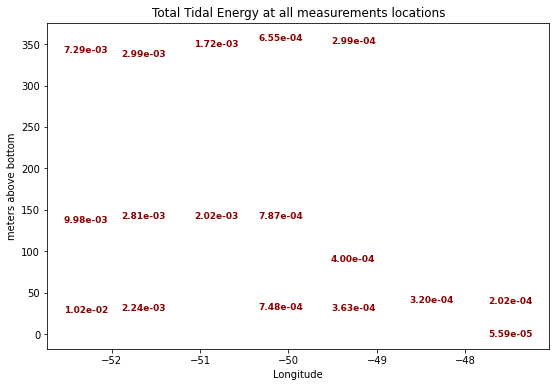

In [8]:
f,a = plt.subplots(figsize = (9,6))
font = {'color':  'darkred',
        'weight': 'bold',
        'size': 9,
        }
for index, row in energy_levels.fillna(0).iterrows():
    a.plot(row['lon'], row['mab'],".", alpha = 0) #{row['energy_level']:.1e}
    text = f"{row['barotropic']+row['baroclinic']:.2e}"    
    a.text(x = row['lon'], y = row['mab'], s= text, va = "center", ha = "center", fontdict = font) 
    
    # Get that exponent value and change it into latex format
    #num, expo = text.split('e')
    #latex_text = num + r'x$\mathregular{10^{%d}}$' %int(expo)
    #a.text(x = row['lon'], y = row['mab'], s= latex_text, va = "center", ha = "center", fontdict = font) 

l,r = a.get_xlim()
a.set_xlim(l-0.2,r+0.2)
a.set_xlabel('Longitude');  
a.set_ylabel('meters above bottom')
a.set_title('Total Tidal Energy at all measurements locations')
f.savefig("./figures/tidal_energy_values.png", dpi = 300)

In [9]:
if False:
    #projection = ccrs.Orthographic(central_longitude=-50, central_latitude=-80)
    projection = ccrs.SouthPolarStereo(central_longitude=-50)
    #projection = ccrs.PlateCarree()
        # Limit the map to -60 degrees latitude and below.


    fig = plt.figure()
    fig.set_size_inches(10,5)
    ax = fig.add_axes([0, 0, 1, 1], projection= projection)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    #ax.set_extent([-140, 40, -60, -80], ccrs.PlateCarree())
    ax.set_extent([-53, -47, -62.5, -64.5], ccrs.PlateCarree())


    lonhelp = np.arange(-80,-10,10)
    lathelp = np.ones(np.shape(lonhelp)) * -65
    #gl.xlocator = mticker.FixedLocator(lonhelp)
    #ax.plot(lonhelp,lathelp,"gs", transform = ccrs.PlateCarree())   
    print(lonhelp,lonhelp.size)

    lathelp = np.arange(-75,-60,5)
    lonhelp = np.ones(np.shape(lathelp)) * -20
    #gl.ylocator = mticker.FixedLocator(lathelp)
    #ax.plot(lonhelp,lathelp,"r.", transform = ccrs.PlateCarree())    



    file_path = "/media/sf_VM_Folder/data/moorings/supermooring.mat"
    struct = sio.loadmat(file_path)
    data = struct["mooring"]

    #load necessary data into usable variables
    lat_list = np.squeeze(data["LAT"])
    lon_list = np.squeeze(data["LON"])

    """
    # ##### Load the data from the southern mooring array
    file_path = "/media/sf_VM_Folder/data/moorings/AQD76S_2018_2021.mat"
    struct = sio.loadmat(file_path)
    data = struct["A"]
    #load necessary data into usable variables
    slat_list = -1*np.squeeze(data["lat"])
    slon_list = -1*np.squeeze(data["lon"])
    """

    # # Load Bathymetry
    bat_data = sio.loadmat("/media/sf_VM_Folder/data/out.mat") 
    bat_data = sio.loadmat("/media/sf_VM_Folder/data/WeddellSea_Bat.mat") 
    bat_lat = bat_data["lat"]
    bat_lon = bat_data["lon"]
    bat_z = bat_data["z"]


    #plot northern moorings
    for i in range(lat_list.size):
        #print(np.squeeze(lon_list[i]),np.squeeze(lat_list[i]))
        ax.plot(np.squeeze(lon_list[i]),np.squeeze(lat_list[i]), "r.", transform = ccrs.PlateCarree())


    #ax.set_title("Mooring Locations in the Weddell Sea, Antarctica")
    divnorm = mcolors.TwoSlopeNorm(vcenter=0)
    #image = plt.contourf(bat_lon, bat_lat, bat_z, 60,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm)#, vmax = 300, vmin = -3500)
    image = plt.contourf(bat_lon, bat_lat, bat_z, 20,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm, vmax = 3000, vmin = -5000)
    plt.colorbar(image,orientation = "horizontal")
    plt.contour(bat_lon, bat_lat, bat_z, 20, linewidths=0.5, linestyles='solid', colors=['black'], alpha=0.4, vmax = 3000, vmin = -5000, transform=ccrs.PlateCarree())

    fig.tight_layout()
    fig.savefig("./figures/local_bathymetry.png", dpi = 300)

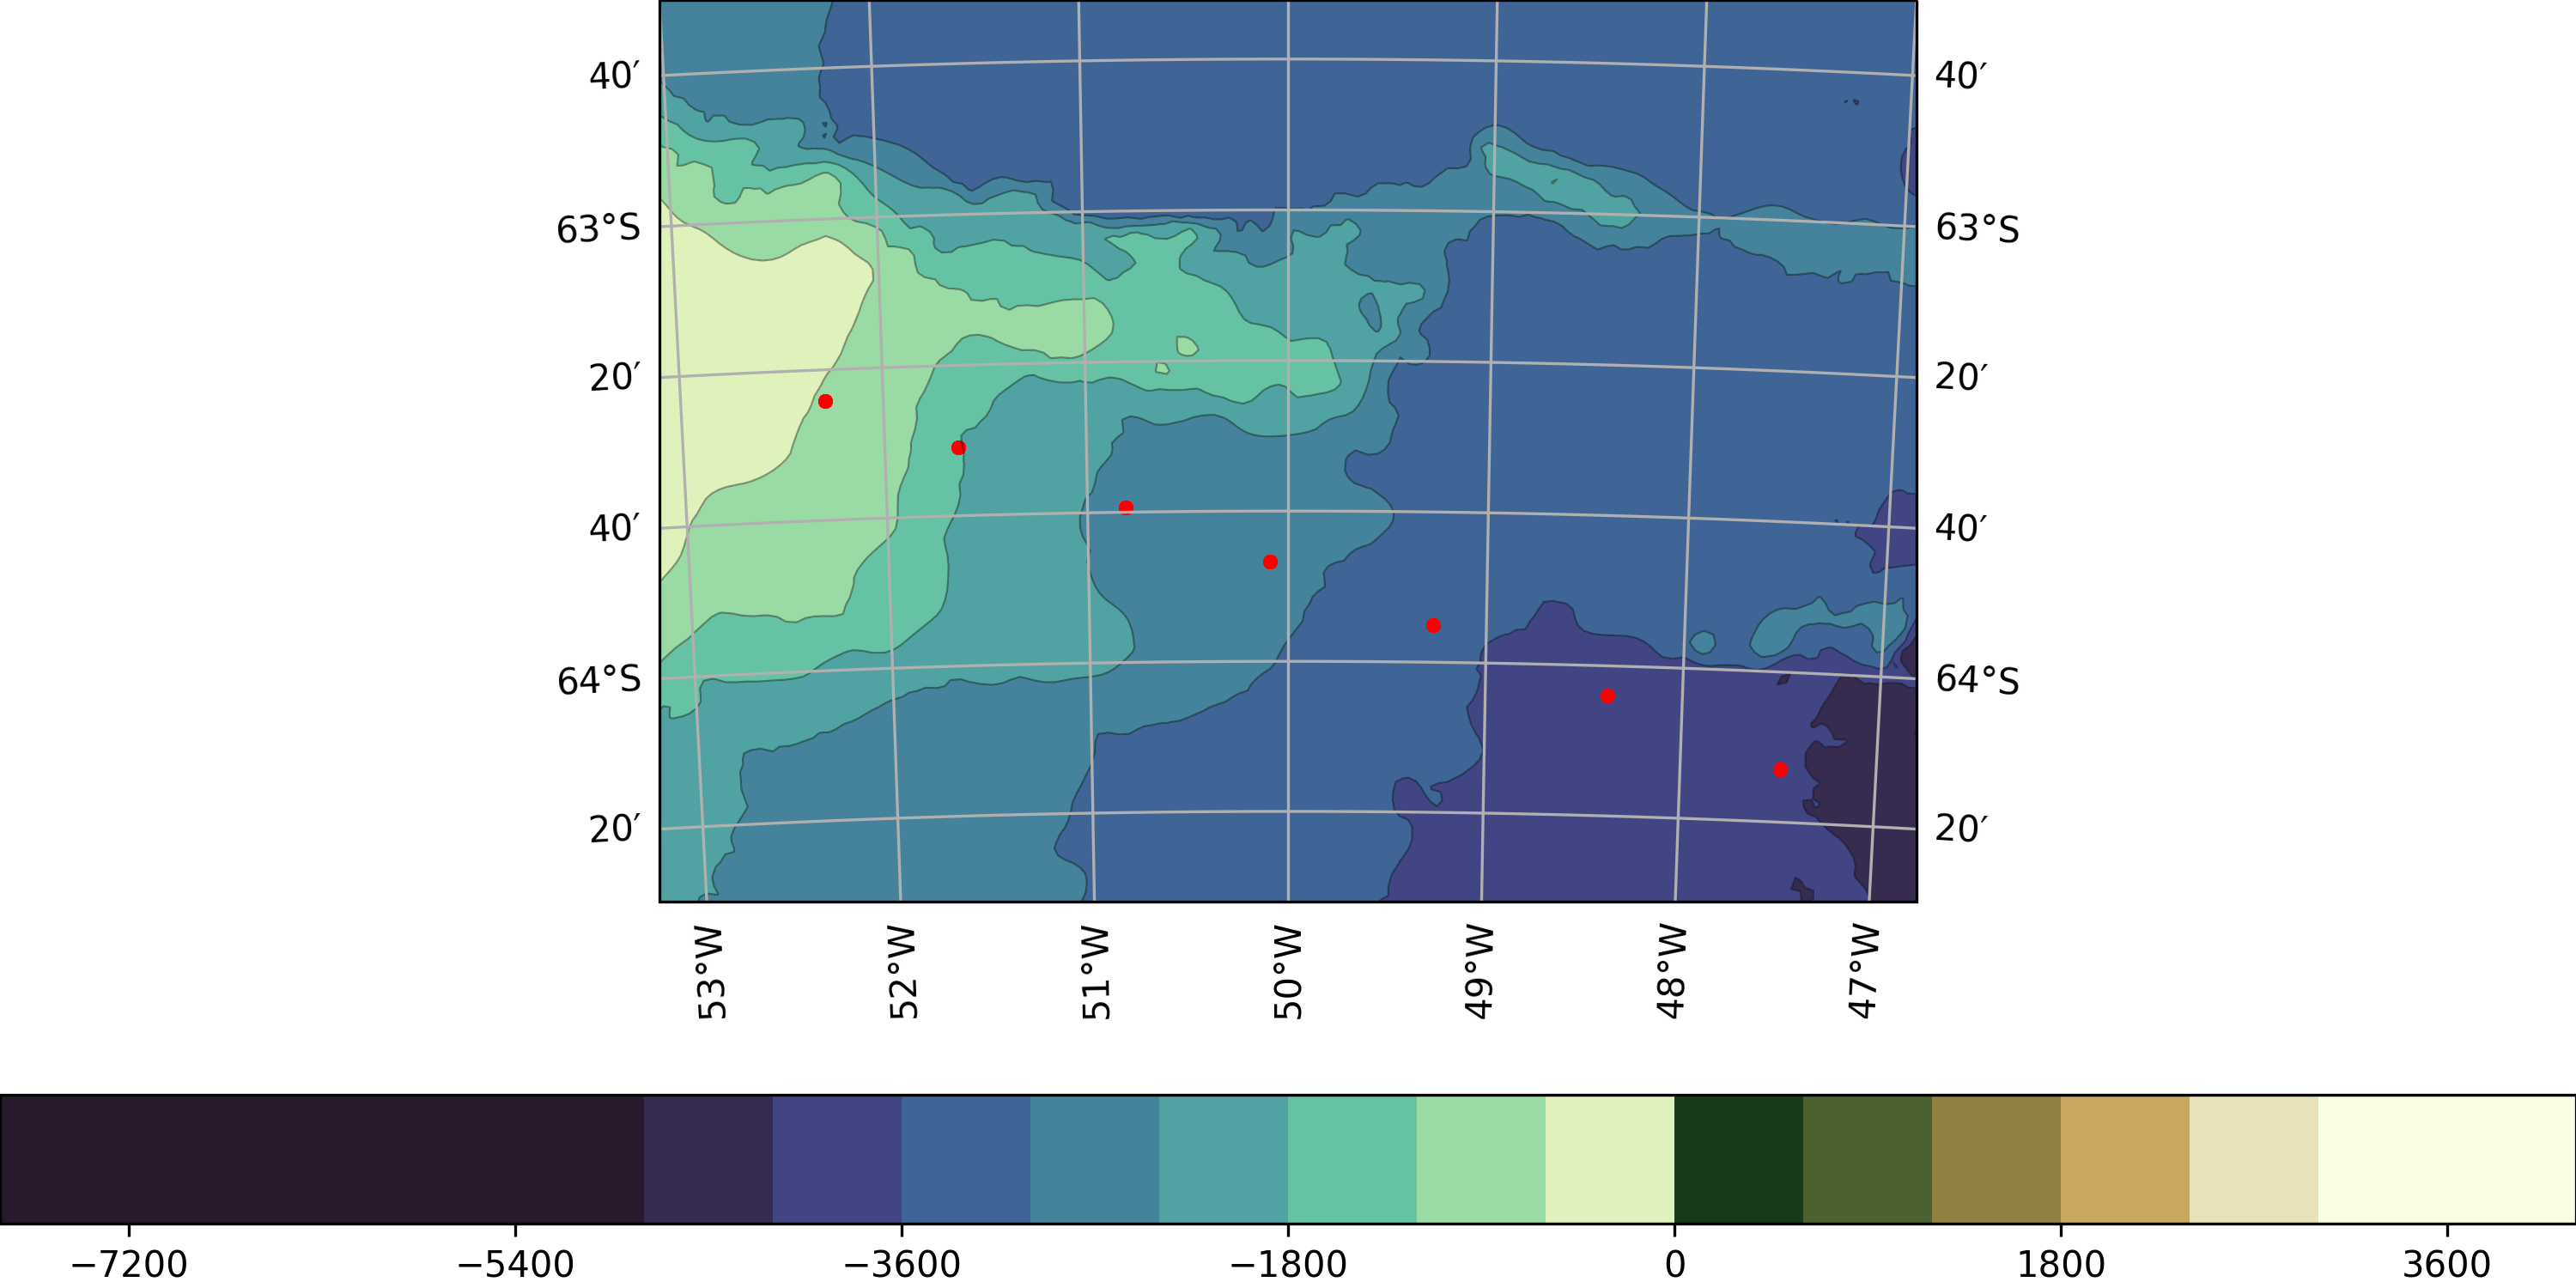

In [10]:
from IPython.display import Image, display;   
display(Image(filename='./figures/local_bathymetry.png', width = 1000))

# The problem

In [11]:
# load all 7 moorings as dataframes
list_of_moorings = helper.IO.load_pickle(name="/home/ole/Desktop/Mooring_Analysis/energy_levels/data/list_of_moorings")

In [12]:
mooring_locations = [mooring.location for mooring in list_of_moorings]
mooring_locations

[Location(lat=-63.4032, lon=-52.287),
 Location(lat=-63.5145, lon=-51.6357),
 Location(lat=-63.656, lon=-50.8113),
 Location(lat=-63.7783, lon=-50.0897),
 Location(lat=-63.917, lon=-49.2682),
 Location(lat=-64.0665, lon=-48.3805),
 Location(lat=-64.2157, lon=-47.4903)]

In [13]:
list_of_moorings

[                           time             299             505  \
 0    2017-01-28 11:49:59.999996  0.2484+0.0378j  0.2033+0.0834j   
 1    2017-01-28 13:49:59.999999  0.2466+0.0314j  0.2179+0.0894j   
 2    2017-01-28 15:50:00.000002  0.2171+0.0049j  0.1939+0.0634j   
 3    2017-01-28 17:49:59.999996  0.1799-0.0124j  0.1290+0.0502j   
 4    2017-01-28 19:49:59.999999  0.1432+0.0299j  0.0924+0.1099j   
 ...                         ...             ...             ...   
 8781 2019-01-30 05:49:59.999996  0.0891+0.0291j  0.1168+0.0880j   
 8782 2019-01-30 07:49:59.999999  0.0968+0.0453j  0.1555+0.0860j   
 8783 2019-01-30 09:50:00.000002  0.0926+0.0534j  0.1716+0.1197j   
 8784 2019-01-30 11:49:59.999996  0.0854+0.0643j  0.1566+0.1388j   
 8785 2019-01-30 13:49:59.999999  0.0663+0.0770j  0.1327+0.1618j   
 
                  614  
 0     0.1482+0.1160j  
 1     0.1649+0.1062j  
 2     0.1491+0.0633j  
 3     0.1031+0.0562j  
 4     0.0732+0.1081j  
 ...              ...  
 8781  0.0988+

3
[299, 505, 614] {299: '#bae4bc', 505: '#7bccc4', 614: '#2b8cbe'}
index_range=(0, 8785)
3
[1318, 1513, 1625] {1318: '#bae4bc', 1513: '#7bccc4', 1625: '#2b8cbe'}
index_range=(0, 6358)
3
[750, 2143, 2350] {750: '#bae4bc', 2143: '#7bccc4', 2350: '#2b8cbe'}
index_range=(0, 5277)
3
[2400, 2615, 2724] {2400: '#bae4bc', 2615: '#7bccc4', 2724: '#2b8cbe'}
index_range=(0, 6952)
3
[3036, 3299, 3358] {3036: '#bae4bc', 3299: '#7bccc4', 3358: '#2b8cbe'}
index_range=(0, 5059)
1
[3835] {3835: '#bae4bc'}
index_range=(0, 8806)
2
[4120, 4160] {4120: '#bae4bc', 4160: '#7bccc4'}
index_range=(0, 8803)


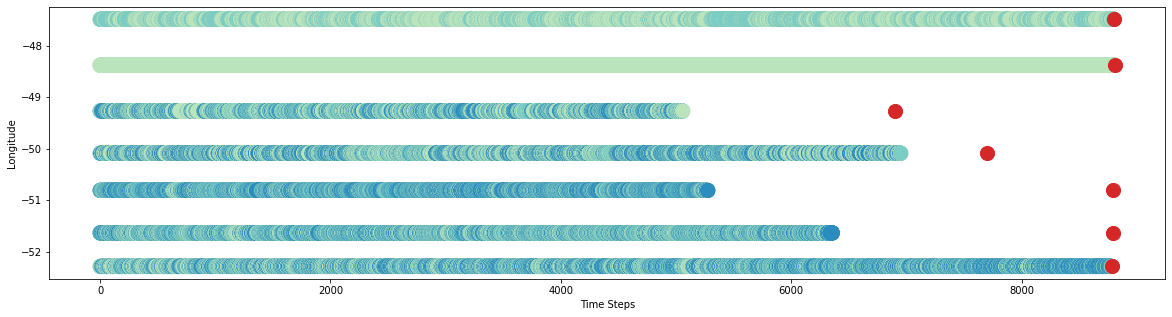

In [14]:
# create the plot
fig, ax = plt.subplots(figsize = (20,5))
color_list = ['#bae4bc','#7bccc4','#2b8cbe']
    
for df in list_of_moorings:
    # get column name of absolute biggest deviation from the temporal mean for each row
    max_cols = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()).apply(lambda x: x.abs().idxmax(), axis=1)

    # define order of columns for color sequence
    
    columns = np.array(list(df.columns)[1:]).astype(int)
    
    column_order = sorted(columns)
    print(len(column_order))
    

    
    color_dict = {k:v for k,v in zip(column_order,color_list)}
    # create a dictionary to map each column to a color
    print(column_order, color_dict)
    
    # create a list of colors based on the max_cols and the color_dict

    colors = [color_dict[int(col)] for col in max_cols]
    
    # create x-axis values based on datetime index of dataframe
    x = df.index

    # create y-axis values from data, excluding the 'time' column
    #y = df.values[:, 1:]

    # plot each column of data using a different color and label
    #for i in range(y.shape[1]):
    #    ax.plot(x, y[:, i], label=df.columns[i+1])
    
    def get_index_range(df):
        """return a tuple of the earliest and latest valid data for all columns in the list"""
        a,b = df.apply(pd.Series.first_valid_index).max(), df.apply(pd.Series.last_valid_index).min()
        return (a,b)

    index_range = get_index_range(df.iloc[:, 1:])
    print(f"{index_range=}")
    
    # add colored points corresponding to the maximum absolute value for each row
    ax.scatter(x[slice(*index_range)], np.ones(len(x))[slice(*index_range)]*df.location.lon, c=colors[slice(*index_range)], s=200)
    ax.scatter(len(df.index),df.location.lon, c = "tab:red", s= 200) #mark length of the longest time series
    
# add legend, x-axis and y-axis labels
#ax.legend()
ax.set_xlabel('Time Steps')
ax.set_ylabel('Longitude');

#ax.set_xlim(0,1000)

# Get CTD Data

In [15]:
columns = ['Event', 'Date/Time', 'Latitude', 'Longitude',
       'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Sal', "Absolute Salinity", "Conservative Temperature", 'Expedition']
CTDs = pd.DataFrame(columns=columns)

In [16]:
#definition of box around the transect 
m = (63.21 - 64.22)/(53.8 - 47)
b = 63.21 - m * 53.8
shift = 0.12

In [17]:
def get_PS129_CTD_data():
    from location import Location
    from ctd_cast import CTDCast
    
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create list of all CTD cast locations
    ctd_locations = []
    ctd_timestamps = []
    for path in ladcp_paths:
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        ctd_locations.append(Location(lat = lat, lon = lon))
        time_stamp = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
        ctd_timestamps.append(time_stamp)
        
    # Set up conversion from ID number to cast name    
    def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate
    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    #create as many CTDCast objects as casts itself
    list_of_PS129_casts= [CTDCast() for _ in ladcp_cast_numbers]

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_PS129_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name
        cast.location = ctd_locations[i]
        cast.date = ctd_timestamps[i]

    column_names = ['Event', "Latitude", "Longitude", "Press [dbar]", "Sal", "Temp [°C]", "Absolute Salinity", "Conservative Temperature", "Date/Time", "Depth water [m]", "Expedition"]
    data_dict = {name:[] for name in column_names}

    for cast in list_of_PS129_casts:
        #load actual data to that Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 322, usecols = (0,1,5), unpack = True)
            data_dict["Event"].extend([f"PS129_{cast.name}"] * len(pressure))
            data_dict["Latitude"].extend([cast.location.lat] * len(pressure))
            data_dict["Longitude"].extend([cast.location.lon] * len(pressure))
            data_dict["Press [dbar]"].extend(pressure)
            data_dict["Temp [°C]"].extend(in_situ_temperature)
            data_dict["Sal"].extend(practical_salinity)
            data_dict["Date/Time"].extend([cast.date] * len(pressure))
            data_dict["Expedition"].extend(["PS129"] * len(pressure))
            
            #add new attributes
            SA = gsw.SA_from_SP(SP = practical_salinity, p = pressure, lon = cast.location.lon, lat = cast.location.lat)
            data_dict["Absolute Salinity"].extend(SA)
            data_dict["Conservative Temperature"].extend(gsw.CT_from_t(SA = SA, t = in_situ_temperature, p = pressure))
            data_dict["Depth water [m]"].extend(np.abs(gsw.z_from_p(p = pressure, lat = cast.location.lat)))
        
        except ValueError as e:
            print("Error at ",cast.name, cast.location)
            print(e)
            continue
        #print(cast.name)     
    #print(data_dict)
    for (k,v) in data_dict.items():
        print(k,len(v))
    return pd.DataFrame(data = data_dict)

In [18]:
PS129_CTDs = get_PS129_CTD_data()
CTDs = CTDs.merge(PS129_CTDs, on = columns, how = "outer")
#Drop all rows that are not even close to the moorings
CTDs.drop(CTDs[CTDs.Latitude < -64.5].index, inplace = True)
CTDs.drop(CTDs[CTDs.Latitude > -63].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude < -54].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude > -47].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b+shift < CTDs.Latitude
].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b-shift > CTDs.Latitude 
].index, inplace = True)

CTDs.reset_index(inplace = True, drop=True)

Error at  018_07 (-59.09,0.12)
Some errors were detected !
    Line #323 (got 1 columns instead of 3)
Event 135941
Latitude 135941
Longitude 135941
Press [dbar] 135941
Sal 135941
Temp [°C] 135941
Absolute Salinity 135941
Conservative Temperature 135941
Date/Time 135941
Depth water [m] 135941
Expedition 135941


In [19]:
def find_line_number(filename, target_string):
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file):
            if line.startswith(target_string):
                return line_number
    return None

In [20]:
data_paths = helper.IO.get_filepaths_from_directory(directory = "/media/sf_VM_Folder/data/CTD", inclusive = ".tab", exclusive = ())
for p in data_paths: print(p)

/media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
/media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
/media/sf_VM_Folder/data/CTD/PS117_phys_oce.tab


PS18 /media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
PS16 /media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
PS40 /media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
PS49 /media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
PS67 /media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
PS71 /media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
PS77 /media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
PS23 /media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
PS103 /media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
PS117 /media/sf_VM_Folder/data/CTD/PS117_phys_oce.tab


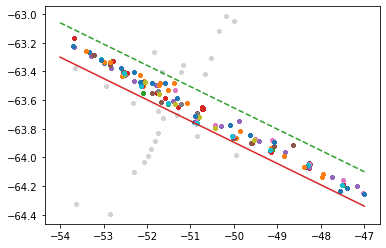

In [21]:
for i, path in enumerate(data_paths):
    target_string = "Event\tDate/Time\tLatitude\tLongitude\tElevation [m]"
    skiprows = find_line_number(path, target_string)
    if skiprows == None:
        target_string = "Event	Type	Date/Time	Longitude"
        skiprows = find_line_number(path, target_string)

    data = pd.read_csv(path, delimiter = "\t", skiprows= skiprows)
    
    data = data[data.columns.intersection(columns)]
    
    #Drop all rows that are not even close to the moorings
    data.drop(data[data.Latitude < -64.5].index, inplace = True)
    data.drop(data[data.Latitude > -63].index, inplace = True)
    data.drop(data[data.Longitude < -54].index, inplace = True)
    data.drop(data[data.Longitude > -47].index, inplace = True)
  
    # plot all CTDs as gret dots
    plt.plot(data.Longitude,data.Latitude, ".", color = "lightgrey")

    # remove every CTD profile outisde a bounding box
    data.drop(data[
        m*data.Longitude-b+shift < data.Latitude
    ].index, inplace = True)
    data.drop(data[
        m*data.Longitude-b-shift > data.Latitude 
    ].index, inplace = True)    
    data.reset_index(inplace = True, drop=True)
    
    data['Date/Time'] =  pd.to_datetime(data['Date/Time'])#, format='%d%b%Y:%H:%M:%S.%f')
    data['Event'] = data['Event'].astype('category')
    
    try:
        if data['Event'].iloc[0][4] != "/": 
            current_expedition = data['Event'].iloc[0][0:5]
        else:
            current_expedition = data['Event'].iloc[0][0:4]
        print(current_expedition, path)
        data['Expedition'] = current_expedition
        assert not data.empty
    
    except IndexError as e:
        print(f"!! Error loading {path}")
        assert data.empty
        continue            
   
    SA = gsw.SA_from_SP(SP = data["Sal"], p = data["Press [dbar]"], lon = data["Longitude"], lat = data["Latitude"])
    data["Absolute Salinity"] = SA
    
    CT = gsw.CT_from_t(SA = data["Absolute Salinity"], t = data["Temp [°C]"], p = data["Press [dbar]"])
    data["Conservative Temperature"] = CT
    
    plt.plot(data.Longitude,data.Latitude, ".", label = path.split("/")[-1])
    CTDs = CTDs.merge(data, on = columns, how = "outer")  
        
CTDs['Event'] = CTDs['Event'].astype('category')    
CTDs['Expedition'] = CTDs['Expedition'].astype('category')  
CTDs = CTDs.copy() #may prevent memory fragmentation created by merging data frames
x = np.linspace(-54,-47,4)
plt.plot(x,m*x-b+shift,"--")    
plt.plot(x,m*x-b-shift) 

#plt.legend()    

In [22]:
CTDs

,Event,Latitude,Longitude,Press [dbar],Sal,Temp [°C],Absolute Salinity,Conservative Temperature,Date/Time,Depth water [m],Expedition
0,PS129_102_01,-64.1310,-47.9530,1.0,33.8873,-1.8490,34.052925,-1.844905,2022-04-20 06:44:16,0.990258,PS129
1,PS129_102_01,-64.1310,-47.9530,2.0,33.8840,-1.8451,34.049596,-1.841016,2022-04-20 06:44:16,1.980511,PS129
2,PS129_102_01,-64.1310,-47.9530,3.0,33.8830,-1.8433,34.048579,-1.839230,2022-04-20 06:44:16,2.970760,PS129
3,PS129_102_01,-64.1310,-47.9530,4.0,33.8836,-1.8438,34.049169,-1.839748,2022-04-20 06:44:16,3.961003,PS129
4,PS129_102_01,-64.1310,-47.9530,5.0,33.8853,-1.8467,34.050865,-1.842667,2022-04-20 06:44:16,4.951242,PS129
...,...,...,...,...,...,...,...,...,...,...,...
281749,PS117_93-1,-63.2557,-53.4054,381.0,34.5890,-0.8440,34.759164,-0.853275,2019-01-31 22:21:00,377.000000,PS117
281750,PS117_93-1,-63.2557,-53.4054,382.0,34.5890,-0.8431,34.759167,-0.852413,2019-01-31 22:21:00,378.000000,PS117
281751,PS117_93-1,-63.2557,-53.4054,383.0,34.5891,-0.8413,34.759271,-0.850655,2019-01-31 22:21:00,378.900000,PS117
281752,PS117_93-1,-63.2557,-53.4054,384.0,34.5895,-0.8390,34.759677,-0.848400,2019-01-31 22:21:00,379.900000,PS117


In [23]:
# Get each mooring location
list_of_moorings = helper.IO.load_pickle(name="/home/ole/Desktop/Mooring_Analysis/energy_levels/data/list_of_moorings")
mooring_locations = [mooring.location for mooring in list_of_moorings]
# create dictionary of the mooring coordinates with empty values
dict_of_closest_ctds = {str(mooring):[] for mooring in mooring_locations}

MAXIMUM_DISTANCE_FROM_MOORING = 20 #in kilometers
NUMBER_OF_CTDs_PER_MOORING = 26

#Look only at casts and their geographic location, the cast data itself will be used later
stats = CTDs.groupby(['Event','Latitude','Longitude']).size().reset_index().rename(columns={0:'count'})
stats = stats.loc[(stats["count"]!=0)]
#drop casts that contain not enough data (alternatively looking at the max depth of each cast would also be possible)
stats.drop(stats[stats["count"] < 200].index, inplace = True) 
stats.reset_index(inplace = True, drop=True)

#Calculate Distances to the mooring locations
for i,mooring_location in enumerate(mooring_locations):
    location_tuple = (mooring_location.lat, mooring_location.lon)
    stats[f"Dist. to {mooring_location}"] = stats.apply(lambda row : geopy_distance(location_tuple, (row.Latitude, row.Longitude)).km, axis = 1)

# select the 3 closest CTD profiles
# Appending to a dataframe is bad form, but I still do it here because teh data frame remains very small

# append names of closest cast to the respective mooring key
for mooring,column_mooring_name in zip(mooring_locations,(list(stats.columns)[4:])):
    # check current mooring against the column name to see if they refer to the same mooring
    #print(str(mooring),column_mooring_name[9:])
    assert str(mooring) == column_mooring_name[9:]

    # sort the dataframe after the distances to the current mooring
    # and get the first 3 closest casts 
    temp = stats.sort_values(by = column_mooring_name)

    list_of_events = temp["Event"].iloc[0:NUMBER_OF_CTDs_PER_MOORING].to_list()
    list_of_distances = temp[column_mooring_name].iloc[0:NUMBER_OF_CTDs_PER_MOORING].to_numpy()

    #replace all cast names with NaNs that are further away from the mooring location than allowed
    is_close = np.less_equal(list_of_distances,MAXIMUM_DISTANCE_FROM_MOORING)
    list_of_events = [event if close else np.nan for (event, close) in zip(list_of_events, is_close) ]

    #for sanity checks, take a look again at the new list_of_distances
    #list_of_distances = [np.round(distance,2) if close else np.nan for (distance, close) in zip(list_of_distances, is_close) ]


    print(mooring)
    print("   ",list_of_events,"\n   ",list_of_distances)

    dict_of_closest_ctds[str(mooring)].extend(list_of_events)

(-63.40,-52.29)
    ['PS103_61-1', 'PS129_119_01', 'PS117_82-1', 'PS67/124-1', 'PS49/005-1', 'PS103_60-1', 'PS81/512-1', 'PS81/513-1', 'PS71/220-2', 'PS129_117_01', 'PS71/221-1', 'PS23/070-2', 'PS77/120-1', 'PS71/221-2', 'PS16/148-1', 'PS23/069-4', 'PS18/041-1', 'PS49/007-3', 'PS18/042-1', 'PS77/111-3', 'PS16/147-1', 'PS16/146-1', 'PS103_62-1', 'PS40/101-1', nan, nan] 
    [ 0.15635909  1.06596929  6.93234935  7.22284917  8.32913869  9.62214074
 11.73997644 11.79570414 11.83122648 11.93444154 12.40380995 12.44207675
 12.50769083 12.76461396 13.07789017 13.18050561 13.49452844 13.74269024
 13.92607705 14.08379199 14.26395879 15.17470196 16.06377155 18.58729255
 22.0135487  22.81245072]
(-63.51,-51.64)
    ['PS103_59-2', 'PS129_114_02', 'PS16/149-1', 'PS117_85-1', 'PS81/514-1', 'PS117_75-1', 'PS77/112-1', 'PS49/006-1', 'PS49/008-1', 'PS49/010-1', 'PS67/123-1', 'PS129_112_01', 'PS129_116_01', 'PS71/218-1', 'PS103_65-1', 'PS23/068-4', 'PS16/150-1', 'PS71/219-1', 'PS40/100-1', 'PS81/109-1',

Now I have a dictionary of the closest CTD casts to the moorings and every cast between 62°$\,$S and 65°$\,$S 
and between 47°$\,$W and 54°$\,$W.

# Look at the closest CTDs

In [24]:
pd.DataFrame(data = dict_of_closest_ctds)

,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,PS103_61-1,PS103_59-2,PS129_109_03,PS103_53-1,PS16/153-1,PS103_48-1,PS40/096-1
1,PS129_119_01,PS129_114_02,PS49/011-3,PS40/098-1,PS23/063-3,PS129_103_01,PS77/103-1
2,PS117_82-1,PS16/149-1,PS49/011-2,PS49/013-1,PS18/046-1,PS23/062-4,PS49/017-1
3,PS67/124-1,PS117_85-1,PS49/011-5,PS81/106-1,PS49/015-2,PS77/104-1,PS71/209-1
4,PS49/005-1,PS81/514-1,PS71/216-5,PS77/107-1,PS129_105_01,PS67/116-1,PS23/061-1
5,PS103_60-1,PS117_75-1,PS49/011-6,PS23/064-1,PS49/015-1,PS49/016-1,PS18/047-1
6,PS81/512-1,PS77/112-1,PS71/216-4,PS67/120-1,PS40/097-1,PS81/103-1,PS103_46-2
7,PS81/513-1,PS49/006-1,PS49/011-4,PS71/214-1,PS81/104-3,PS71/210-3,PS81/102-1
8,PS71/220-2,PS49/008-1,PS81/516-1,PS18/045-1,PS67/118-1,PS71/210-2,PS67/114-1
9,PS129_117_01,PS49/010-1,PS71/216-1,PS67/119-1,PS71/212-1,NaN,PS67/115-1


In [25]:
def smooth(array,length):
    window = signal.windows.hann(length)  # construct Hanning window
    smoothed = signal.convolve(array, window, mode="same") / np.sum(window)  # smooth by convolving speed with window
    return smoothed

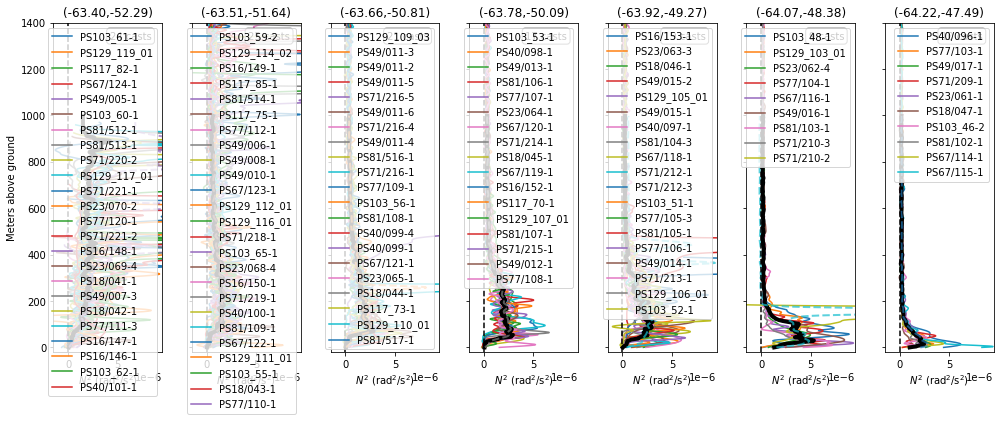

In [26]:
f,axis = plt.subplots(ncols = len(mooring_locations), sharey = True, sharex = True, figsize = (14,6))

comparison_z_axis = np.arange(0,1000,2)

CTDs_grouped = CTDs.groupby("Event")

smoothing_window_size = 32
for ax, (mooring, closest_ctd_casts) in zip(axis,dict_of_closest_ctds.items()):
    ax.set_title(mooring)
    ax.axvline(0, color = "k", ls = "--", zorder = 5)
    #print(closest_ctd_casts, pd.isna(closest_ctd_casts))
    number_of_valid_profiles = (~pd.isna(closest_ctd_casts)).sum()
    ax.text(0.9,0.95, s= f"{number_of_valid_profiles} casts", ha = "right", transform=ax.transAxes, bbox=dict(facecolor='white', alpha = 0.6, edgecolor='black', boxstyle='round'))

    # for calculating mean N2 profile for each mooring
    N2_array = []
    for cast_name in closest_ctd_casts:
        if pd.isna(cast_name): continue       

        #retrieve data 
        cast = CTDs_grouped.get_group(cast_name)

        #calculate square of buoyancy frequency    
        N2, N2pressure = gsw.Nsquared(
            SA = cast["Absolute Salinity"],
            CT = cast["Conservative Temperature"],
            p = cast["Press [dbar]"],
            lat = cast["Latitude"])
        depth = -1*gsw.z_from_p(p = N2pressure, lat = cast["Latitude"].mean()) 

        #convert N2 from (rad/s)^2 to 1/s^2
        #N2 = N2_in_radians / (2*np.pi)**2
        if smoothing_window_size != 0:
            N2 = smooth(N2,smoothing_window_size)

        # change vertical coordinate 
        # to "meters above ground" or "distance from seafloor"
        mab = max(depth) - depth
        ax.plot(N2,mab, label = cast_name)

        # interpolate to common grid
        new_N2 = np.interp(
            x = comparison_z_axis,
            xp = mab[::-1], #mab and N2 are reversed so that mab monotonically increases
            fp = N2[::-1]
            )
        N2_array.append(new_N2)

    mean_N2 = np.nanmean(N2_array, axis = 0)  #calculating the average
    median_N2 = np.nanmedian(N2_array, axis = 0)  #calculating the average
    #std_N2 = np.std(N2_array, axis = 0)


    ax.plot(median_N2, comparison_z_axis, "k", lw = 4) #plot median N2
    ax.plot(mean_N2, comparison_z_axis, "--", lw = 2, alpha = 0.7) #plot mean N2
    ax.set_xlabel("$N^2$ (rad$^2$/s$^2$)")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.legend(loc = "upper right")
        
axis[0].set_ylabel("Meters above ground")
axis[0].set_ylim(-20,1400)
axis[0].set_xlim(-1.5e-6,9.5e-6)
#axis[0].set_xlim(-1.5e-6,5e-4)
f.tight_layout()
    
    

In [27]:
BBL_CTDs = ["PS103_62-1","PS117_85-1", "PS129_120_01","PS103_59-2","PS129_114_02", "PS103_56-1", "PS103_53-1", "PS103_52-1", "PS103_47-1", "PS129_100_03"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


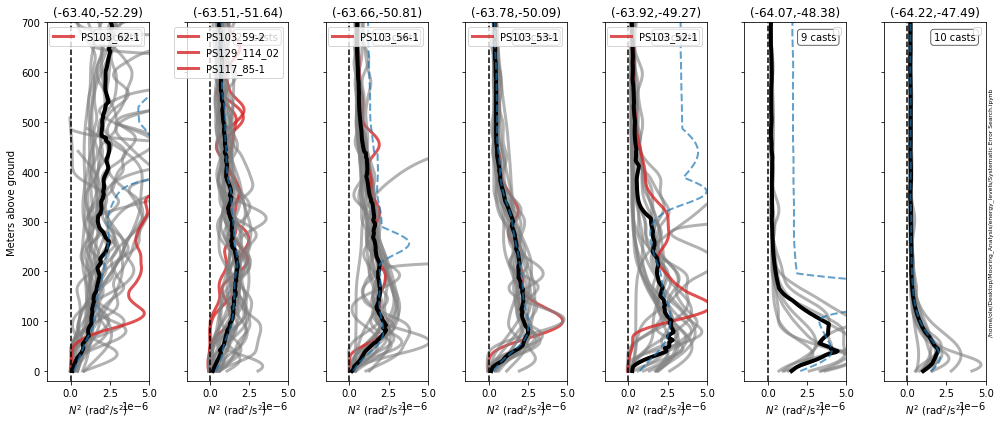

In [28]:
f,axis = plt.subplots(ncols = len(mooring_locations), sharey = True, sharex = True, figsize = (14,6))

comparison_z_axis = np.arange(0,1000,2)

CTDs_grouped = CTDs.groupby("Event")

smoothing_window_size = 100
for ax, (mooring, closest_ctd_casts) in zip(axis,dict_of_closest_ctds.items()):
    ax.set_title(mooring)
    ax.axvline(0, color = "k", ls = "--", zorder = 5)
    #print(closest_ctd_casts, pd.isna(closest_ctd_casts))
    number_of_valid_profiles = (~pd.isna(closest_ctd_casts)).sum()
    ax.text(0.9,0.95, s= f"{number_of_valid_profiles} casts", ha = "right", transform=ax.transAxes, bbox=dict(facecolor='white', alpha = 0.6, edgecolor='black', boxstyle='round'))

    # for calculating mean N2 profile for each mooring
    N2_array = []
    for cast_name in closest_ctd_casts:
        if pd.isna(cast_name): continue       

        #retrieve data 
        cast = CTDs_grouped.get_group(cast_name)

        #calculate square of buoyancy frequency    
        N2, N2pressure = gsw.Nsquared(
            SA = cast["Absolute Salinity"],
            CT = cast["Conservative Temperature"],
            p = cast["Press [dbar]"],
            lat = cast["Latitude"])
        depth = -1*gsw.z_from_p(p = N2pressure, lat = cast["Latitude"].mean()) 

        #convert N2 from (rad/s)^2 to 1/s^2
        #N2 = N2_in_radians / (2*np.pi)**2
        if smoothing_window_size != 0:
            N2 = smooth(N2,smoothing_window_size)

        # change vertical coordinate 
        # to "meters above ground" or "distance from seafloor"
        mab = max(depth) - depth
        if cast_name in BBL_CTDs:
            ax.plot(N2,mab, lw = 3, c = "tab:red", alpha = 0.8, label = cast_name)

        else:
            ax.plot(N2,mab, lw = 3, c = "grey", alpha = 0.6)

        # interpolate to common grid
        new_N2 = np.interp(
            x = comparison_z_axis,
            xp = mab[::-1], #mab and N2 are reversed so that mab monotonically increases
            fp = N2[::-1]
            )
        N2_array.append(new_N2)

    mean_N2 = np.nanmean(N2_array, axis = 0)  #calculating the average
    median_N2 = np.nanmedian(N2_array, axis = 0)  #calculating the average
    #std_N2 = np.std(N2_array, axis = 0)


    ax.plot(median_N2, comparison_z_axis, "k", lw = 4) #plot median N2
    ax.plot(mean_N2, comparison_z_axis, "--", lw = 2, alpha = 0.7) #plot mean N2
    ax.set_xlabel("$N^2$ (rad$^2$/s$^2$)")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.legend(loc = "upper right")
        
axis[0].set_ylabel("Meters above ground")
axis[0].set_ylim(-20,700)
axis[0].set_xlim(-1.5e-6,5e-6)
f.tight_layout()
helper.Plot.path_as_footnote(fig = f, 
                             path = "/home/ole/Desktop/Mooring_Analysis/energy_levels/Systematic Error Search.ipynb", 
                             rot = "vertical")

f.savefig("./figures/BBL_CTDS.png", dpi = 300)

In [29]:
if False:
    import gvpy
    #projection = ccrs.Orthographic(central_longitude=-50, central_latitude=-80)
    projection = ccrs.SouthPolarStereo(central_longitude=-50)
    #projection = ccrs.PlateCarree()
    # Limit the map to -60 degrees latitude and below.

    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_axes([0, 0, 1, 1], projection= projection)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    ax.set_extent([-53, -47, -63, -64.3], ccrs.PlateCarree())

    file_path = "/media/sf_VM_Folder/data/moorings/supermooring.mat"
    struct = sio.loadmat(file_path)
    data = struct["mooring"]

    #load necessary data into usable variables
    lat_list = np.squeeze(data["LAT"])
    lon_list = np.squeeze(data["LON"])

    # # Load Bathymetry
    #bat_data = sio.loadmat("/media/sf_VM_Folder/data/out.mat") 
    bat_data = sio.loadmat("/media/sf_VM_Folder/data/WeddellSea_Bat.mat") 
    bat_lat = bat_data["lat"]
    bat_lon = bat_data["lon"]
    bat_z = bat_data["z"]


    #plot northern moorings
    for i in range(lat_list.size):
        ax.plot(np.squeeze(lon_list[i]),np.squeeze(lat_list[i]), "kD", markersize = 10 , transform = ccrs.PlateCarree(), zorder = 12)


    #ax.set_title("Mooring Locations in the Weddell Sea, Antarctica")
    divnorm = mcolors.TwoSlopeNorm(vcenter=0)
    #image = plt.contourf(bat_lon, bat_lat, bat_z, 60,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm)#, vmax = 300, vmin = -3500)
    image = ax.contourf(bat_lon, bat_lat, bat_z, 20,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm, vmax = 3000, vmin = -5000)
    
    plt.colorbar(image, ax = ax, orientation = "horizontal", shrink=0.5)
    
    ax.contour(bat_lon, bat_lat, bat_z, 20, linewidths=0.5, linestyles='solid', colors=['black'], alpha=0.4, vmax = 3000, vmin = -5000, transform=ccrs.PlateCarree())

    fig.tight_layout()

    for i, (mooring, closest_ctd_casts) in enumerate(dict_of_closest_ctds.items()):
        for cast_name in closest_ctd_casts:
            if pd.isna(cast_name): continue

            #retrieve data 
            cast = CTDs_grouped.get_group(cast_name)

            color = "grey"
            markersize = 20  
            zorder = 20
            if cast_name in BBL_CTDs:
                color = "tab:red"
                zorder = 50
   
            ax.plot(cast["Longitude"].mean(), cast["Latitude"].mean(), ".", markersize = markersize, color = color, markeredgewidth=1, markeredgecolor = "black", zorder = zorder, transform=ccrs.PlateCarree())

    gvpy.maps.cartopy_scale_bar(ax, location = (0.3,0.1), length = MAXIMUM_DISTANCE_FROM_MOORING) 
    fig.savefig("map_CTD_locations.png", dpi = 300)    


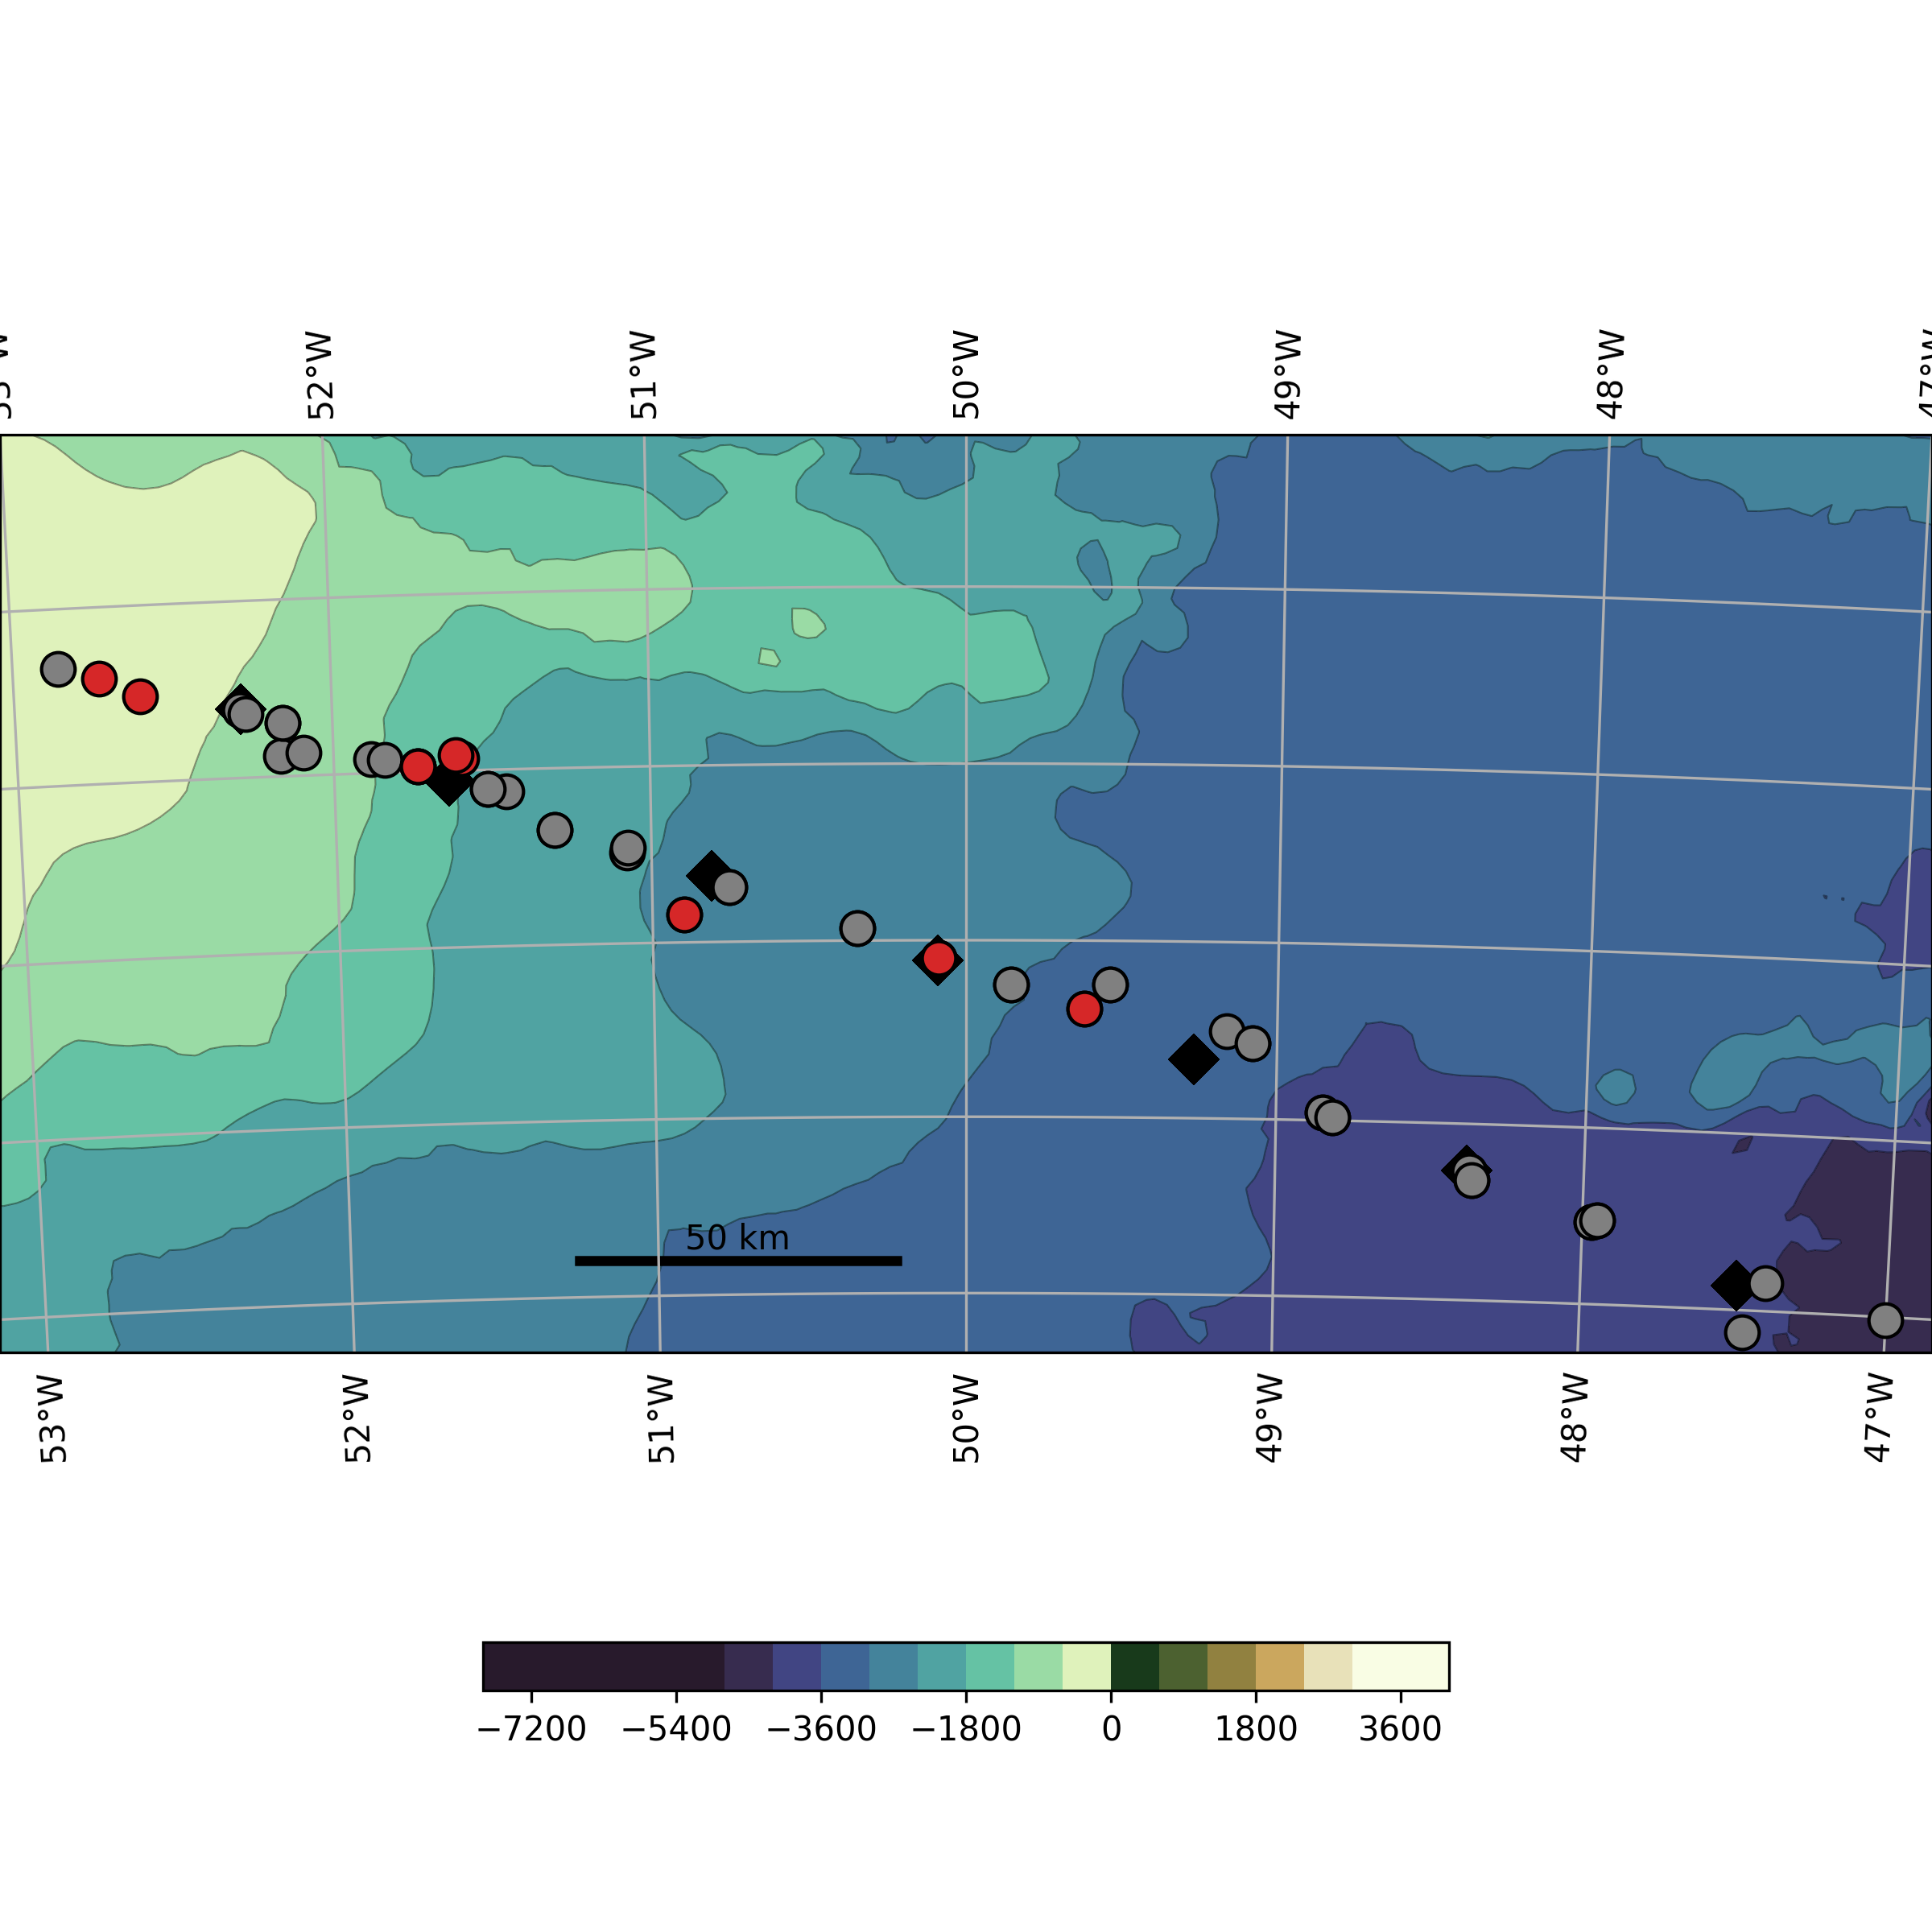

In [30]:
from IPython.display import Image, display;   
display(Image(filename="./figures/map_CTD_locations.png", width = 700))

NameError: name 'PS103_grouped' is not defined

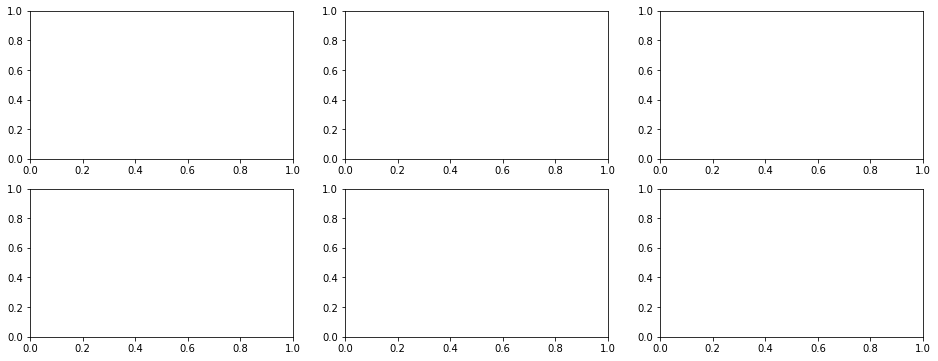

In [31]:
color_list = ['#bae4bc','#7bccc4','#2b8cbe']
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16,6))
mooring = list_of_moorings[1]
time = mooring["time"]

#for depth, color in zip(list_of_moorings[1].iloc[:, 1:],color_list):
#    print(depth)
#    ax[0].plot(time,np.real(mooring[depth]), c = color)
#    ax[1].plot(time,np.imag(mooring[depth]), c = color)

import matplotlib.dates as mdates
import matplotlib.units as munits
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

for i,(coordinates, closest_ctd_casts) in enumerate(dict_of_closest_ctds.items()):

    for cast_name in closest_ctd_casts:
        if pd.isna(cast_name): continue
        if cast_name[:5] == "PS103": 
            grouped = PS103_grouped
            col = 0
        if cast_name[:5] == "PS117":
            grouped = PS117_grouped
            col = 1
        if cast_name[:5] == "PS129":
            grouped = PS129_grouped
            col = 2

        #retrieve data 
        cast = grouped.get_group(cast_name)    
        color = "grey"    
        if cast_name in BBL_CTDs:
            color = "tab:red"

        #retrieve data 
        cast = grouped.get_group(cast_name)    
        ax[0,col].axvline(cast["Date/Time"].iloc[0], ls = '--', lw = 4, c = color)
        ax[1,col].axvline(cast["Date/Time"].iloc[0], ls = '--', lw = 4, c = color)
        
        for a in ax.flatten():
            a.autoscale(enable=True, axis='x', tight=True)

                  
mooring = list_of_moorings[1]     
for depth, color in zip(list_of_moorings[1].iloc[:, 1:],color_list):
    #print(depth)
    xlim0=  ax[0,0].get_xlim()
    xlim1=  ax[0,1].get_xlim()
    ax[0,0].plot(time,np.real(mooring[depth]), c = color, lw = 5)
    ax[1,0].plot(time,np.imag(mooring[depth]), c = color, lw = 5)
    ax[0,1].plot(time,np.real(mooring[depth]), c = color, lw = 5)
    ax[1,1].plot(time,np.imag(mooring[depth]), c = color, lw = 5)
    ax[0,0].set_xlim(*xlim0)
    ax[1,0].set_xlim(*xlim0)
    ax[0,1].set_xlim(*xlim1)
    ax[1,1].set_xlim(*xlim1)    

print(sorted(BBL_CTDs))            
fig.tight_layout()

# Focus on AWI261-1 at 51.6°$\,$W

In [ ]:
unusual_CTDs = ["PS103_59-2","PS117_85-1","PS129_114_02"] 

In [ ]:
f,ax = plt.subplots(ncols = 1, sharey = True, sharex = True, figsize = (5,6))

comparison_z_axis = np.arange(0,600)

mooring, closest_ctd_casts = list(dict_of_closest_ctds.items())[1]

ax.set_title(mooring)
ax.axvline(0, color = "k", ls = "--", zorder = 5)
#print(closest_ctd_casts, pd.isna(closest_ctd_casts))
number_of_valid_profiles = (~pd.isna(closest_ctd_casts)).sum()
ax.text(0.9,0.95, s= f"{number_of_valid_profiles} casts", ha = "right", transform=ax.transAxes, bbox=dict(facecolor='white', alpha = 0.6, edgecolor='black', boxstyle='round'))

# for calculating mean N2 profile for each mooring
N2_array = []
for cast_name in closest_ctd_casts:
    if pd.isna(cast_name): continue       

    #retrieve data 
    cast = CTDs_grouped.get_group(cast_name)

    #calculate square of buoyancy frequency    
    N2, N2pressure = gsw.Nsquared(
        SA = cast["Absolute Salinity"],
        CT = cast["Conservative Temperature"],
        p = cast["Press [dbar]"],
        lat = cast["Latitude"])
    depth = -1*gsw.z_from_p(p = N2pressure, lat = cast["Latitude"].mean()) 

    #convert N2 from (rad/s)^2 to 1/s^2
    #N2 = N2_in_radians / (2*np.pi)**2
    if smoothing_window_size != 0:
        N2 = smooth(N2,smoothing_window_size)

    # change vertical coordinate 
    # to "meters above ground" or "distance from seafloor"
    mab = max(depth) - depth

    if cast_name in unusual_CTDs:
        ax.plot(N2,mab, lw = 3, c = "tab:red", alpha = 0.8, label = cast_name)
        #ax.plot(N2,mab, lw = 3, c = "grey", alpha = 0.8, label = cast_name)
        #print(f"Mean N = {np.nanmean(np.sqrt(N2)):.2e}")   
        
    else:
        #ax.plot(N2,mab, lw = 3, label = cast_name)
        ax.plot(N2,mab, lw = 3, c = "grey", alpha = 0.6)

        
    # interpolate to common grid
    new_N2 = np.interp(
        x = comparison_z_axis,
        xp = mab[::-1], #mab and N2 are reversed so that mab monotonically increases
        fp = N2[::-1]
        )
    N2_array.append(new_N2)

mean_N2 = np.nanmean(N2_array, axis = 0)  #calculating the average
median_N2 = np.nanmedian(N2_array, axis = 0)  #calculating the average
#std_N2 = np.std(N2_array, axis = 0)


ax.plot(median_N2, comparison_z_axis, "k", lw = 4) #plot median N2
ax.plot(mean_N2, comparison_z_axis, "--", lw = 2, alpha = 0.7) #plot mean N2
ax.set_xlabel("$N^2$ (rad$^2$/s$^2$)")
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.legend(loc = "upper right")
    
ax.set_ylim(-20,340)
ax.set_xlim(-0.5e-6,4e-6)
helper.Plot.path_as_footnote(fig = f, 
                             path = "/home/ole/Desktop/Mooring_Analysis/energy_levels/Systematic Error Search", 
                             rot = "vertical")
f.tight_layout()
f.savefig("./figures/BBL_CTDS_AWI261-1.png", dpi = 300)

In [ ]:
unusual_CTDs = ["PS103_59-2","PS117_85-1","PS129_114_02", ]
test_cases = ["PS49/010-1", "PS81/514-1", "PS49/008-1", "PS49/006-1", ]
unusual_CTDs += test_cases 
#, "PS77/112-1", "PS23/068-4"]

In [ ]:
unusual_CTDs

In [ ]:
if True:
    import gvpy
    #projection = ccrs.Orthographic(central_longitude=-50, central_latitude=-80)
    projection = ccrs.SouthPolarStereo(central_longitude=-50)
    #projection = ccrs.PlateCarree()
    # Limit the map to -60 degrees latitude and below.

    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_axes([0, 0, 1, 1], projection= projection)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    ax.set_extent([-53, -51, -63.1, -63.75], ccrs.PlateCarree())

    file_path = "/media/sf_VM_Folder/data/moorings/supermooring.mat"
    struct = sio.loadmat(file_path)
    data = struct["mooring"]

    #load necessary data into usable variables
    lat_list = np.squeeze(data["LAT"])
    lon_list = np.squeeze(data["LON"])

    # # Load Bathymetry
    bat_data = sio.loadmat("/media/sf_VM_Folder/data/out.mat") 
    bat_data = sio.loadmat("/media/sf_VM_Folder/data/WeddellSea_Bat.mat") 
    bat_lat = bat_data["lat"]
    bat_lon = bat_data["lon"]
    bat_z = bat_data["z"]


    #plot northern moorings
    for i in range(lat_list.size):
        ax.plot(np.squeeze(lon_list[i]),np.squeeze(lat_list[i]), "kD", markersize = 10 , transform = ccrs.PlateCarree(), zorder = 12)


    #ax.set_title("Mooring Locations in the Weddell Sea, Antarctica")
    divnorm = mcolors.TwoSlopeNorm(vcenter=0)
    #image = plt.contourf(bat_lon, bat_lat, bat_z, 60,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm)#, vmax = 300, vmin = -3500)
    image = ax.contourf(bat_lon, bat_lat, bat_z, 20,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm, vmax = 3000, vmin = -5000)
    
    plt.colorbar(image, ax = ax, orientation = "horizontal", shrink=0.5)
    
    ax.contour(bat_lon, bat_lat, bat_z, 20, linewidths=0.5, linestyles='solid', colors=['black'], alpha=0.4, vmax = 3000, vmin = -5000, transform=ccrs.PlateCarree())

    fig.tight_layout()

    for i, (mooring, closest_ctd_casts) in enumerate(dict_of_closest_ctds.items()):
        for cast_name in closest_ctd_casts:
            if pd.isna(cast_name): continue
            
            #retrieve data 
            cast = CTDs_grouped.get_group(cast_name)

            color = "grey"
            markersize = 20  
            zorder = 20
            if cast_name in unusual_CTDs:
                color = "tab:red"
                zorder = 50
            if i != 1:
                color = "lightgrey"
                zorder = 10
   
            ax.plot(cast["Longitude"].mean(), cast["Latitude"].mean(), ".", markersize = markersize, color = color, markeredgewidth=1, markeredgecolor = "black", zorder = zorder, transform=ccrs.PlateCarree())

    gvpy.maps.cartopy_scale_bar(ax, location = (0.3,0.1), length = MAXIMUM_DISTANCE_FROM_MOORING) 
    ax.text(0.2,0.02,"/home/ole/Desktop/Mooring_Analysis/energy_levels/Systematic Error Search.ipynb", transform = ax.transAxes)
    fig.savefig("./figures/map_AWI261-1_CTD_locations.png", dpi = 300)    

In [ ]:
from IPython.display import Image, display;   
display(Image(filename="./figures/map_AWI261-1_CTD_locations.png", width = 700))

In [ ]:
print(list_of_moorings[1].location)
list_of_moorings[1]

In [ ]:
color_list = ['#bae4bc','#7bccc4','#2b8cbe']
fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (10,6))
mooring = list_of_moorings[1]
time = mooring["time"]

for depth, color in zip(list_of_moorings[1].iloc[:, 1:],color_list):
    print(depth)
    ax[0].plot(time,np.real(mooring[depth]), c = color)
    ax[1].plot(time,np.imag(mooring[depth]), c = color)
    
for cast_name in unusual_CTDs[:-1]:
    if cast_name[:5] == "PS103": grouped = PS103_grouped
    if cast_name[:5] == "PS117": grouped = PS117_grouped
    if cast_name[:5] == "PS129": grouped = PS129_grouped
    
    #retrieve data 
    cast = grouped.get_group(cast_name)    
    for a in ax:
        a.axvline(cast["Date/Time"].iloc[0], ls = '--', c = "k")

# Kinetic to Total Energy

\begin{equation} 
\mathcal{E} = \frac{N² - f²}{N² - \omega²}\frac{\omega²}{\omega² + f²} \mathcal{U}
\end{equation}

In [ ]:
def kinetic_to_total_energy_factor(N,f,omega):
    return (N**2 - f**2)/(N**2 - omega**2) * (omega**2)/(omega**2 + f**2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = np.logspace(-4,-3,100)
plt.plot(x,kinetic_to_total_energy_factor(N=0.003, f = 0.0001, omega = x))